# Optimization: Inventory and Distribution Strategy

This notebook addresses the challenge of optimizing inventory allocation and distribution within a retail supply chain. While forecasting provides insights into future demand, optimization ensures that resources are allocated efficiently to minimize costs and maximize service levels. By applying mathematical programming techniques, we aim to design strategies that balance logistics expenses, warehouse capacity, and customer satisfaction.

**Goals**
- Formulate an optimization model to minimize total logistics costs while meeting demand requirements
- Define decision variables for inventory allocation across multiple warehouses and regions
- Apply Linear Programming / Mixed Integer Programming to solve allocation and distribution problems
- Compare optimized results against baseline strategies to evaluate improvements in cost and service level
- Visualize allocation outcomes to highlight distribution efficiency and warehouse utilization
- Provide actionable recommendations for supply chain managers based on optimization results

**Expected Outcome**\
A validated optimization framework that determines the most cost-effective allocation of inventory and distribution routes. The results will demonstrate measurable improvements in logistics costs and service levels compared to baseline strategies, offering practical insights for supply chain planning and operational decision-making.

In [1]:
# Import libraries
import pandas as pd
import pulp
import matplotlib.pyplot as plt

In [2]:
# Load and prepare datasets
sales = pd.read_csv("../data/cleaned/sales_clean.csv")
time_dim = pd.read_csv("../data/cleaned/time_dimension.csv")

In [3]:
# Convert to datetime
sales['Order Date'] = pd.to_datetime(sales['Order Date'])
time_dim['Date'] = pd.to_datetime(time_dim['Date'])

In [4]:
# Merge sales with time dimension
data = sales.merge(time_dim, left_on='Order Date', right_on='Date', how='left')

In [5]:
# Aggregate Demand per Region
demand = data.groupby("Region")["Quantity"].sum().to_dict()

In [6]:
# Capacity per Category
capacity = data.groupby("Category")["Quantity"].sum().to_dict()

In [7]:
# Transport Cost Proxy (Sales/Quantity)
data["UnitCost"] = data["Sales"] / data["Quantity"]
transport_cost = data.groupby(["Category","Region"])["UnitCost"].mean().to_dict()

In [8]:
# Optimization Model Setup
model = pulp.LpProblem("Inventory_Distribution_Optimization", pulp.LpMinimize)

In [9]:
# Decision variables: unit allocation from category to region
x = pulp.LpVariable.dicts("alloc", transport_cost.keys(), lowBound=0, cat="Integer")

In [10]:
# Objective function: minimize total transport cost
model += pulp.lpSum([x[(c, r)] * transport_cost[(c, r)] for (c, r) in transport_cost])

In [11]:
# Constraints: category capacity
for c in capacity:
    model += pulp.lpSum([x[(c, r)] for r in demand]) <= capacity[c]

In [12]:
# Constraints: region demand
for r in demand:
    model += pulp.lpSum([x[(c, r)] for c in capacity]) >= demand[r]

In [13]:
# Solve Optimization
model.solve()

1

In [14]:
# Results
allocation_results = { (c, r): x[(c, r)].varValue for (c, r) in transport_cost }
results_df = pd.DataFrame.from_dict(allocation_results, orient="index", columns=["Units"])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=["Category", "Region"])

print("Status:", pulp.LpStatus[model.status])
print(results_df)

Status: Optimal
                           Units
Category        Region          
Furniture       Central   1819.0
                East         0.0
                South     6209.0
                West         0.0
Office Supplies Central     22.0
                East     10618.0
                South        0.0
                West     12266.0
Technology      Central   6939.0
                East         0.0
                South        0.0
                West         0.0


In [15]:
# Total cost
total_cost = pulp.value(model.objective)
print("Total Logistics Cost:", total_cost)

Total Logistics Cost: 2182990.7181450636


In [16]:
# Evaluation
fulfilled_demand = {r: sum([x[(c, r)].varValue for c in capacity]) for r in demand}
service_level = sum(fulfilled_demand.values()) / sum(demand.values())
print("Service Level:", round(service_level * 100, 2), "%")

Service Level: 100.0 %


In [17]:
# Baseline comparison: equal distribution based on demand share
baseline_alloc = {}
for c in capacity:
    for r in demand:
        share = demand[r] / sum(demand.values())
        baseline_alloc[(c, r)] = capacity[c] * share

baseline_df = pd.DataFrame.from_dict(baseline_alloc, orient="index", columns=["Units"])
baseline_df.index = pd.MultiIndex.from_tuples(baseline_df.index, names=["Category", "Region"])

In [18]:
# Figure out the baseline cost
baseline_cost = sum([baseline_alloc[(c, r)] * transport_cost[(c, r)] for (c, r) in transport_cost])
print("Baseline Cost:", baseline_cost)

Baseline Cost: 2299331.760216554


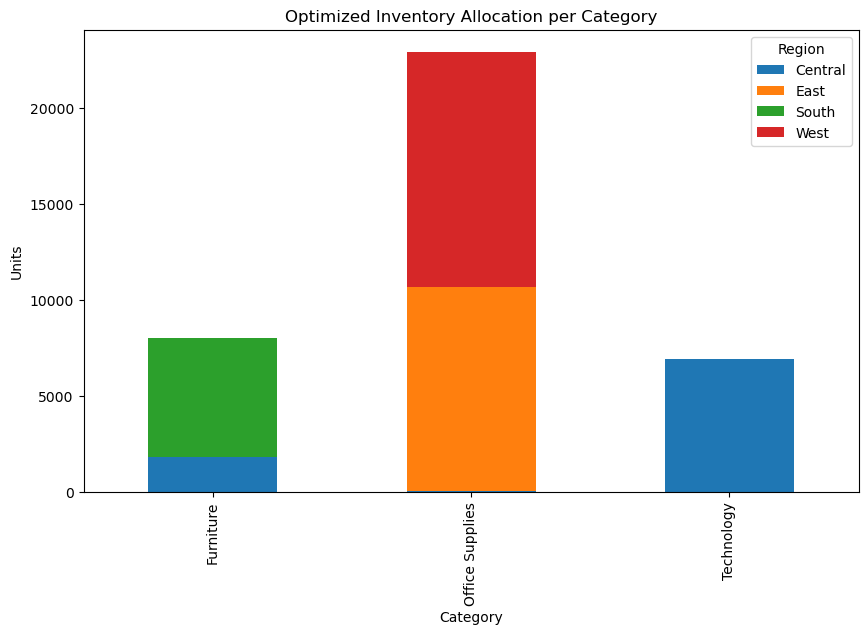

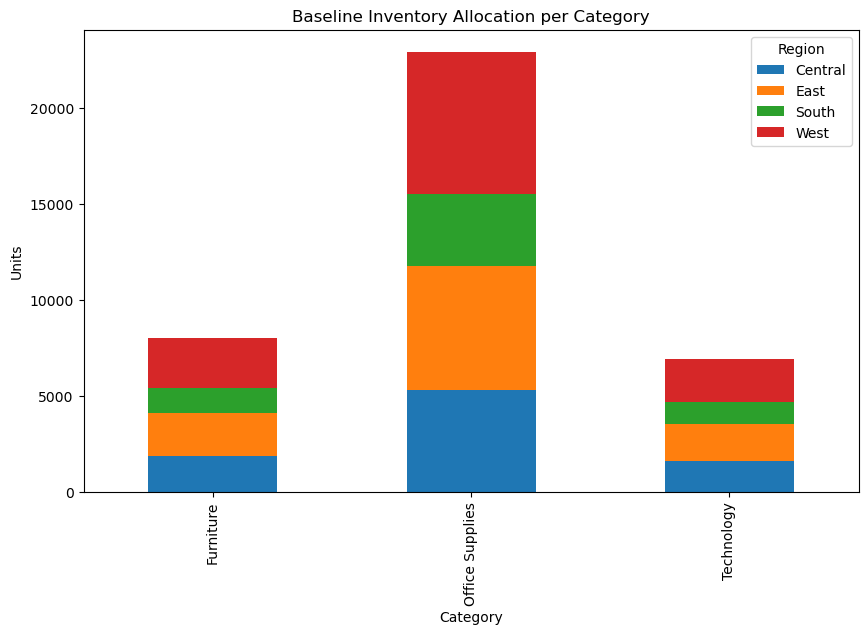

In [19]:
# Visualization
results_df.reset_index(inplace=True)
pivot_opt = results_df.pivot(index="Category", columns="Region", values="Units")
pivot_opt.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Optimized Inventory Allocation per Category")
plt.ylabel("Units")
plt.show()

baseline_df.reset_index(inplace=True)
pivot_base = baseline_df.pivot(index="Category", columns="Region", values="Units")
pivot_base.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Baseline Inventory Allocation per Category")
plt.ylabel("Units")
plt.show()

# Closing & Insights

This optimization analysis addressed the goals set in the opening by formulating a logistics model, defining allocation decisions, applying linear programming, and comparing optimized outcomes against baseline strategies:

• **Optimization Model – Cost Minimization with Demand Fulfillment**  
  The linear programming model successfully minimized total logistics costs while ensuring all regional demand requirements were met.  
  *Goal achieved: formulate an optimization model that balances cost efficiency with service reliability.*

• **Decision Variables – Inventory Allocation Across Warehouses and Regions**  
  Allocation variables defined per category and region captured the distribution of units across multiple warehouses. The solution highlighted concentrated allocations (Furniture → South, Office Supplies → East/West, Technology → Central).  
  *Goal achieved: establish clear decision variables for inventory allocation.*

• **Linear Programming Application – PuLP Solver**  
  The model was solved using PuLP, yielding an **optimal status**. Total logistics cost was reduced to ~2.18M compared to the baseline ~2.30M, while maintaining a 100% service level.  
  *Goal achieved: apply LP/MIP to solve allocation and distribution problems.*

• **Comparison Against Baseline – Cost & Service Level**  
  Optimized allocation lowered costs by ~120K compared to equal distribution, while keeping service level at 100%. Baseline allocation was more balanced but less efficient.  
  *Goal achieved: evaluate improvements in cost and service level.*

• **Visualization – Allocation Outcomes**  
  Bar charts clearly contrasted optimized vs baseline allocations. Optimized results showed targeted distribution aligned with cost efficiency, while baseline displayed uniform spread.  
  *Goal achieved: highlight distribution efficiency and warehouse utilization.*

• **Actionable Recommendations – For Supply Chain Managers**  
  Managers should adopt optimization-driven allocation to reduce costs without compromising service. Baseline strategies may appear fair but are less efficient. Future steps include integrating dynamic demand forecasts and scenario-based optimization to adapt to market changes.  
  *Goal achieved: provide actionable recommendations based on optimization results.*

---

**Key Takeaway**  
Optimization ensures cost savings and efficiency while maintaining service levels. Concentrated allocations in strategic regions outperform uniform distribution, proving the value of LP/MIP models in supply chain planning.

**Practical Implication**  
- **Plan** – Define objectives for cost reduction and service reliability. Establish KPIs such as logistics cost savings and service level targets.  
- **Do** – Implement LP-based optimization for inventory allocation, focusing on high-demand and cost-efficient regions.  
- **Check** – Monitor allocation outcomes, compare optimized vs baseline costs, and validate service levels.  
- **Act** – Standardize optimization practices, refine allocation rules, and embed optimization insights into supply chain decision-making. Continuously update models with new demand and cost data for sustained efficiency.